### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML 

pd.set_option('display.max_columns', 500)

%pip install openpyxl
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


### Carregamento do dados

In [2]:
df = pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#')

### Tratamento dos dados

In [3]:
#Remover linhas sem valor da variável target (Profit)
df = df[df['Profit'].notna()]
#Remover variaveis nominais
df = df.drop(columns = ['Product ID','Customer ID','Postal Code', 'Customer Name', 'Product Name'])
#Garantir que nao existem valores null
assert(df.isnull().sum().sum() == 0)

In [4]:
#Transformar variaveis categóricos no type category
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['City'] = df['City'].astype('category')
df['State'] = df['State'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Market'] = df['Market'].astype('category')
df['Region'] = df['Region'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')

In [5]:
#Tratar das datas
columns = df.columns
if 'Order Date' in columns and 'Ship Date' in columns:
    order_dates = DatetimeIndex(pd.to_datetime(df['Order Date'],format='%d-%m-%Y', errors='coerce'))
    df['order_day'] = order_dates.day
    df['order_month'] = order_dates.month
    df['order_year'] = order_dates.year

    ship_dates = DatetimeIndex(pd.to_datetime(df['Ship Date'],format='%d-%m-%Y', errors='coerce'))
    df['ship_year'] = ship_dates.year
    df['ship_month'] = ship_dates.month
    df['ship_day'] = ship_dates.day

    df = df.drop(['Order Date', 'Ship Date'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51200 entries, 32298 to 6147
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Order ID        51200 non-null  object  
 1   Ship Mode       51200 non-null  category
 2   Segment         51200 non-null  category
 3   City            51200 non-null  category
 4   State           51200 non-null  category
 5   Country         51200 non-null  category
 6   Market          51200 non-null  category
 7   Region          51200 non-null  category
 8   Category        51200 non-null  category
 9   Sub-Category    51200 non-null  category
 10  Sales           51200 non-null  float64 
 11  Quantity        51200 non-null  float64 
 12  Discount        51200 non-null  float64 
 13  Profit          51200 non-null  float64 
 14  Shipping Cost   51200 non-null  float64 
 15  Order Priority  51200 non-null  object  
 16  order_day       51200 non-null  int64   
 17  order_mon

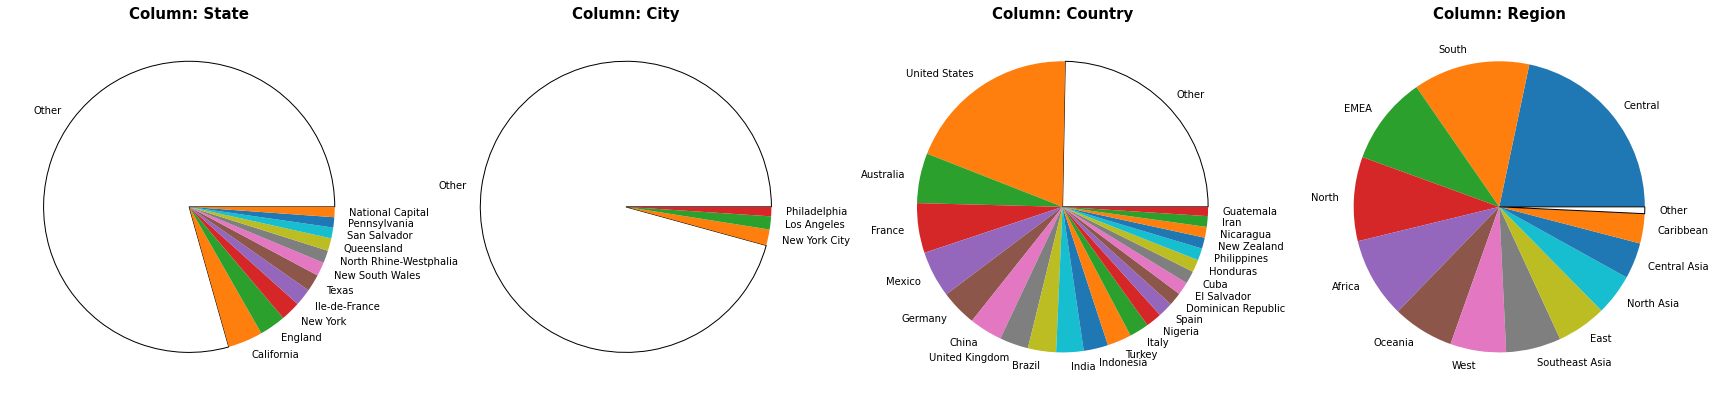

In [7]:
#Otherização dados -> dados que correspondem a menos de 1% das amostras
#sao categorizadas como "other"

colunas = ["State", "City", "Country", "Region"]
for coluna in colunas:
    series = df.value_counts(df[coluna])
    mask = (series/series.sum() * 100).lt(1)
    df[coluna] = np.where(df[coluna].isin(series[mask].index),'Other',df[coluna])


fig = plt.figure(1, figsize=[30,10])
fig_nr_columns = 4
fig_nr_rows = 1

for k in range(len(colunas)):
    coluna = colunas[k]
    coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
    coluna_percentagens = coluna_percentagens.reset_index()
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    wedges, labels = ax.pie(coluna_percentagens[coluna], labels=coluna_percentagens["index"])
    for w, l in zip(wedges, labels):
        if l.get_text() == 'Other':
            w.set_color('white')
            w.set_edgecolor('black')
    plt.title("Column: {}".format(coluna), fontweight='bold', fontsize=15)


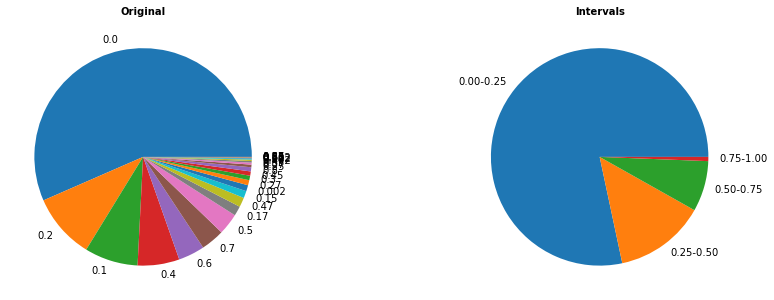

In [8]:
#Agrupar valor de desconto em intervalos
nr_bins = 5
if is_numeric_dtype(df['Discount']):
    limits_bins = np.linspace(0, 1, num=nr_bins)
    labels_names = []
    for i in range(0, len(limits_bins) - 1):
        v1 = '{:.2f}'.format(limits_bins[i])
        v2 = '{:.2f}'.format(limits_bins[i+1])
        labels_names.append(f'{v1}-{v2}')
    df['discount_bracket'] = pd.cut(x = df['Discount'], bins = limits_bins, labels = labels_names, include_lowest = True)

fig = plt.figure(1, figsize=[15,5])
ax = fig.add_subplot(1, 2, 1)
coluna = "Discount"
coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
coluna_percentagens = coluna_percentagens.reset_index()
ax.pie(coluna_percentagens[coluna], labels=coluna_percentagens["index"])
plt.title("Original", fontweight='bold', fontsize=10)

ax = fig.add_subplot(1, 2, 2)
coluna = "discount_bracket"
coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
coluna_percentagens = coluna_percentagens.reset_index()
ax.pie(coluna_percentagens[coluna], labels=coluna_percentagens["index"])
plt.title("Intervals", fontweight='bold', fontsize=10)
plt.show()

In [9]:
# Juntar datasets de países com PIB por anos
df_pib = pd.read_csv('pibs.csv')

# Nós criamos um dicionário que associa o país ao index para depois a procura ser mais rápida
# A key é o país, o value é o index no dataframe
countries_index = {}
for index, row in df_pib.iterrows():
#    countries_index[row['Country Name']] = index
    countries_index[row['Country Name']] = index
    


In [10]:
df_copy = df

available_years = [2011, 2012, 2013, 2014]

# Para o caso de mais países terem nomes diferentes nos 2 datasets
def convert_countries_name(value):
    if (value=='Iran'):
        return "Iran, Islamic Rep."
    else:
        return value

'''
Atribuímos o valor do primeiro quartil para um país que tenha menos de 1%. 
Esse valor é usado para países que foram marcados como "Other".
'''
def add_pib_value():
    gdp_by_years = {}
    for year in available_years:
        print(year)
        print(df_pib[str(year)].quantile([0.25])[0.25])
        gdp_by_years[year] = df_pib[str(year)].quantile([0.25])[0.25]
    
    return gdp_by_years

# Dicionário que associa anos ao primeiro quartil do PIB desse ano
gdp_to_Other_countries_dic = add_pib_value()



def add_pib_value(value):

    country = convert_countries_name(value['Country'])
    year = value['order_year']
    if (country == 'Other'):
        return gdp_to_Other_countries_dic[year]
    index_in_df = countries_index[country]
    
    gdp_in_year = df_pib.iloc[index_in_df]
    #Corresponder o ano ao index no df de pib
    year_index = year-2011+1;

    return gdp_in_year[year_index]

df_copy['pib_country'] = df_copy.apply (lambda row: add_pib_value(row), axis=1)
df = df_copy


2011
8106590716.75
2012
8709165249.0
2013
8747773729.5
2014
9297230738.0


In [11]:
# Label encoding de algumas variáveis
lb_make = LabelEncoder()

if all(value in ["Category", "Sub-Category", "Discount"] for value in df.columns):
    df["Category LabelEnc"] = lb_make.fit_transform(df["Category"])
    df["Sub-Category LabelEnc"] = lb_make.fit_transform(df["Sub-Category"])
    df["Discount LabelEnc"] = lb_make.fit_transform(df["Discount"])
    df = df.drop(["Category", "Sub-Category", "Discount"], axis=1)


if df['Ship Mode'].dtype == 'category' or df['Ship Mode'].dtype == 'object':
    ship_mode_dic = {'Same Day':1, 'First Class':2, 'Second Class':3,'Standard Class':4}
    df["Ship Mode"]= df["Ship Mode"].apply(lambda x: ship_mode_dic.get(x))

if "Order_Priority" in df and (df['Order_Priority'].dtype == 'category' or df['Order_Priority'].dtype == 'object'):
    priorities_dic = {'Critical':1, 'High':2, 'Medium':3,'Low':4}
    df["Order_Priority"]= df["Order_Priority"].apply(lambda x: priorities_dic.get(x))
    
df.head(2)

,Order ID,Ship Mode,Segment,City,State,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,order_day,order_month,order_year,ship_year,ship_month,ship_day,discount_bracket,pib_country
Row ID,,,,,,,,,,,,,,,,,,,,,,,,
32298,CA-2012-124891,1,Consumer,New York City,New York,United States,US,East,Technology,Accessories,2309.650,7.0,0.0,762.1845,933.57,Critical,31,7,2012,2012,7,31,0.00-0.25,1.619700e+13
26341,IN-2013-77878,3,Corporate,Other,New South Wales,Australia,APAC,Oceania,Furniture,Chairs,3709.395,9.0,0.1,-288.7650,923.63,Critical,5,2,2013,2013,2,7,0.00-0.25,1.576340e+12


<AxesSubplot:>

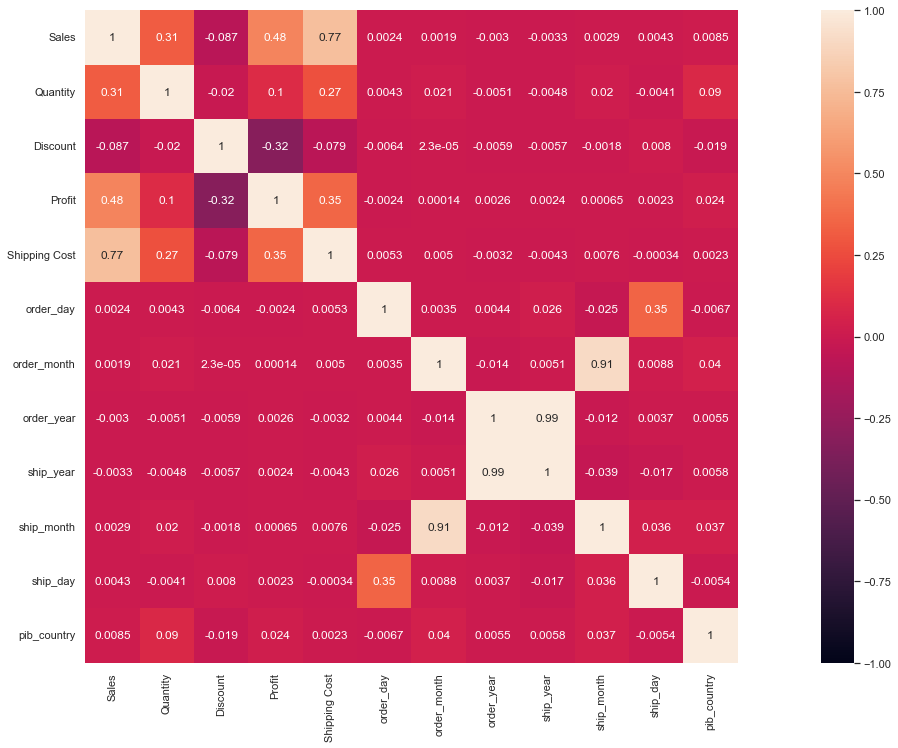

In [12]:
corr_matrix = df.corr()
sns.set(rc={'figure.figsize':(30,12)})
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True,annot=True)

<AxesSubplot:ylabel='Row ID'>

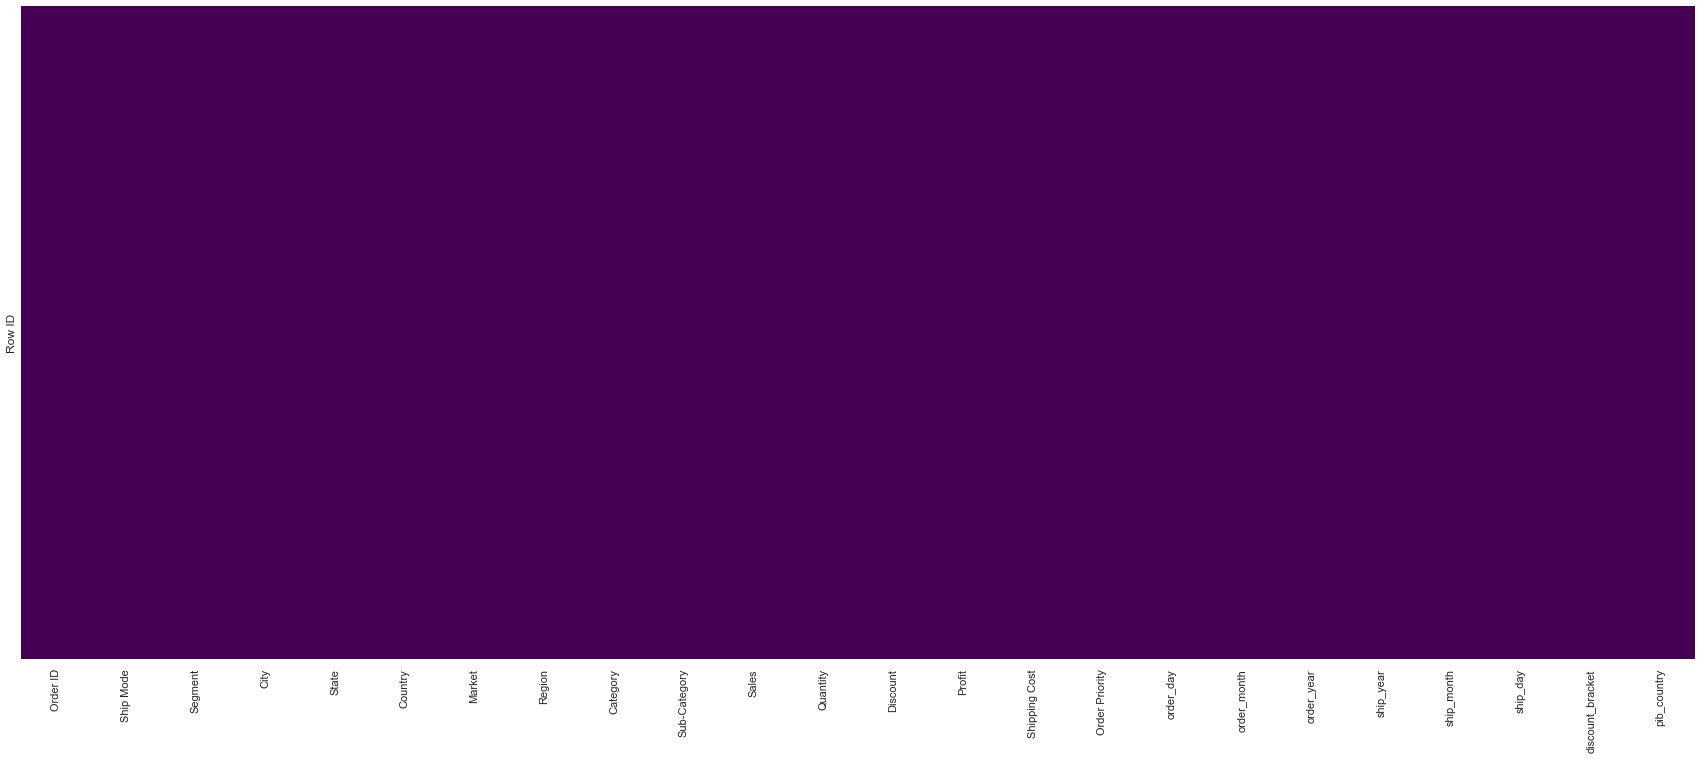

In [13]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [14]:
df.loc[df['Ship Mode'] == 4 ,'ship_mode_binned'] = 0
df.loc[df['Ship Mode'] != 4 ,'ship_mode_binned'] = 1
    
df.head(2)

,Order ID,Ship Mode,Segment,City,State,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,order_day,order_month,order_year,ship_year,ship_month,ship_day,discount_bracket,pib_country,ship_mode_binned
Row ID,,,,,,,,,,,,,,,,,,,,,,,,,
32298,CA-2012-124891,1,Consumer,New York City,New York,United States,US,East,Technology,Accessories,2309.650,7.0,0.0,762.1845,933.57,Critical,31,7,2012,2012,7,31,0.00-0.25,1.619700e+13,1.0
26341,IN-2013-77878,3,Corporate,Other,New South Wales,Australia,APAC,Oceania,Furniture,Chairs,3709.395,9.0,0.1,-288.7650,923.63,Critical,5,2,2013,2013,2,7,0.00-0.25,1.576340e+12,1.0


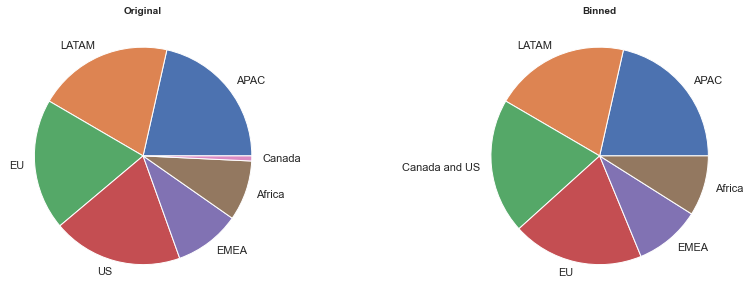

In [15]:
if (df['Market'].dtypes == 'category'):
    df.loc[df['Market'] == 'Canada' ,'Market_binned'] = 'Canada and US'
    df.loc[df['Market'] == 'US' ,'Market_binned'] = 'Canada and US'
    df.loc[df['Market'] == 'APAC' ,'Market_binned'] = 'APAC'
    df.loc[df['Market'] == 'EU' ,'Market_binned'] = 'EU'
    df.loc[df['Market'] == 'Africa' ,'Market_binned'] = 'Africa'
    df.loc[df['Market'] == 'EMEA' ,'Market_binned'] = 'EMEA'
    df.loc[df['Market'] == 'LATAM' ,'Market_binned'] = 'LATAM'

fig = plt.figure(1, figsize=[15,5])
ax = fig.add_subplot(1, 2, 1)
coluna = "Market"
coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
coluna_percentagens = coluna_percentagens.reset_index()
ax.pie(coluna_percentagens[coluna], labels=coluna_percentagens["index"])
plt.title("Original", fontweight='bold', fontsize=10)

ax = fig.add_subplot(1, 2, 2)
coluna = "Market_binned"
coluna_percentagens = (df[coluna].value_counts()/df[coluna].count())*100
coluna_percentagens = coluna_percentagens.reset_index()
ax.pie(coluna_percentagens[coluna], labels=coluna_percentagens["index"])
plt.title("Binned", fontweight='bold', fontsize=10)
plt.show()


In [16]:
ids_cols = ['Order ID', 'Market' ]
for item in ids_cols: 
    if item in df.columns:
        df = df.drop(item, axis=1)

df.head(1)

,Ship Mode,Segment,City,State,Country,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,order_day,order_month,order_year,ship_year,ship_month,ship_day,discount_bracket,pib_country,ship_mode_binned,Market_binned
Row ID,,,,,,,,,,,,,,,,,,,,,,,,
32298,1,Consumer,New York City,New York,United States,East,Technology,Accessories,2309.65,7.0,0.0,762.1845,933.57,Critical,31,7,2012,2012,7,31,0.00-0.25,1.619700e+13,1.0,Canada and US


In [17]:
from sklearn.preprocessing import LabelEncoder

# Label encoding de algumas variáveis
lb_make = LabelEncoder()
categorical_columns = df.select_dtypes(exclude=["number","bool_"]).columns

for item in categorical_columns:
    df[item] = lb_make.fit_transform(df[item])

In [18]:
df.to_csv("new_Global_Superstore_With_Outliers.csv")

In [19]:
df_new=df.copy(deep=True)

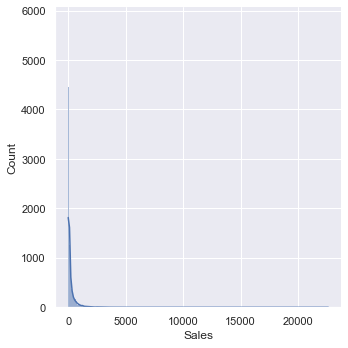

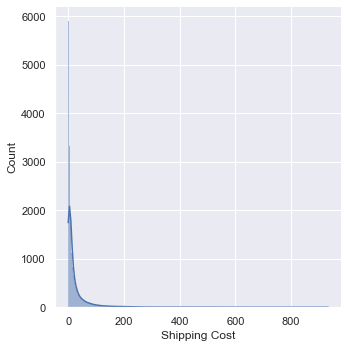

In [20]:
sns.displot(df['Sales'],kde=True)
sns.displot(df['Shipping Cost'], kde=True)

In [21]:
### Tratar os outliers das features numéricas:
### Substituir os valores dos outliers pela mediana

array = []

for num in ["Sales","Shipping Cost"]:
    Q1 = df_new[num].quantile(0.25)
    Q3 = df_new[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    array.append((num,lower,upper))

print(array)

i = 0
for num in ["Sales","Shipping Cost"]:
    median = np.median(df_new[num])
    df_new.loc[df_new[num] <= array[i][1], num] = median
    df_new.loc[df_new[num] >= array[i][2], num] = median
    i = i + 1


[('Sales', -300.26, 582.78), ('Shipping Cost', -30.245, 57.395)]


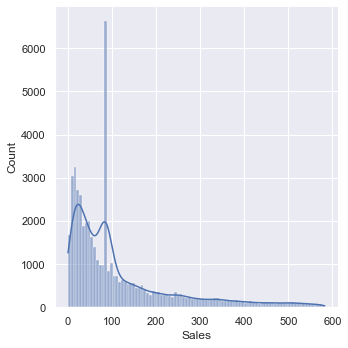

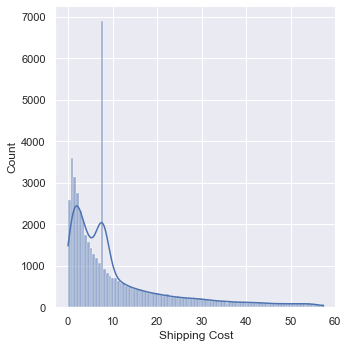

In [22]:
sns.displot(df_new['Sales'], kde=True)
sns.displot(df_new['Shipping Cost'], kde=True)

In [23]:
#Remove rows with outlier values
def is_outlier(points, thresh=3.5):
    """
    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

for c in ["Sales","Shipping Cost"]:
    df = df.loc[~is_outlier(df[c])]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7848\2613556874.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


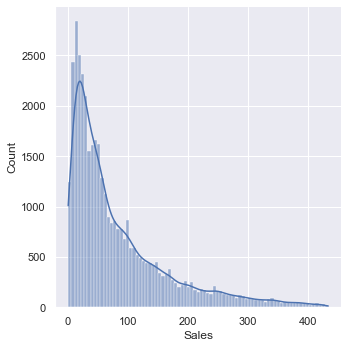

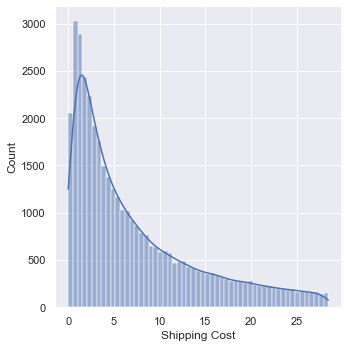

In [24]:
sns.displot(df['Sales'], kde=True)
sns.displot(df['Shipping Cost'], kde=True)

In [25]:
df.to_csv("new_Global_Superstore_Without_Outliers.csv")